In [1]:
import numpy as np
import soundfile as sf
import noisereduce as nr
import librosa
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from tensorflow.lite.python.interpreter import Interpreter


/Users/ahmed/Desktop/boeung-sne/birdc/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/ahmed/Desktop/boeung-sne/birdc/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [ ]:

def load_birdnet_model(model_path="models/birdnet/audio-model.tflite"):
    """Load BirdNET TFLite model"""
    interpreter = Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    return interpreter

def load_labels(labels_path="models/birdnet/labels/en_us.txt"):
    """Load species labels"""
    with open(labels_path, "r", encoding="utf-8") as f:
        return [line.strip() for line in f if line.strip()]

def preprocess_audio(audio_path, target_sr=48000):
    """Load, convert to mono, resample to 48 kHz, and normalize safely"""
    # Load audio file
    y, sr = sf.read(audio_path, dtype="float32")

    # Convert stereo → mono
    if y.ndim > 1:
        y = np.mean(y, axis=1)

    # Resample if needed
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)

    # Normalize to range [-1, 1]
    max_val = np.max(np.abs(y))
    if max_val > 0:
        y = y / max_val

    return y.astype("float32")


In [ ]:

def predict_species(interpreter, audio, labels, top_k=10):
    """Run inference on audio"""
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    
    expected_len = input_details[0]["shape"][1]
    

    if len(audio) < expected_len:
        audio = np.pad(audio, (0, expected_len - len(audio)))
    else:
        audio = audio[:expected_len]
    
   
    audio_input = audio[None, :]  # Add batch dimension [1, N]
    interpreter.set_tensor(input_details[0]["index"], audio_input)
    interpreter.invoke()
    
    # Get predictions
    logits = interpreter.get_tensor(output_details[0]["index"])[0]
    probs = 1.0 / (1.0 + np.exp(-logits))  # Sigmoid i.e 
    # logits = [-5.2,  3.8,  -0.3]
    #probs  = [0.005, 0.98, 0.43]
    
    # Get top predictions
    top_indices = np.argsort(probs)[::-1][:top_k]
    results = []
    for idx in top_indices:
        results.append({
            "label": labels[idx],
            "score": float(probs[idx])
        })
    return results

In [ ]:
def analyze_full_recording(audio_path, interpreter, labels, min_conf=0.5):
    """
    Analyze entire recording by breaking into 3-sec windows with overlap
    """
    print(f"\nAnalyzing: {audio_path}")
    
    # Load audio at 32kHz
    y = preprocess_audio(audio_path, target_sr=32000)
    print(f"Loaded {len(y)/32000:.1f} seconds of audio")
    
    # Resample to 48kHz for BirdNET
    y_48k = librosa.resample(y=y, orig_sr=32000, target_sr=48000)
    
    # window config 1.5 second overap
    window_samples = 144000  # 3 sec at 48kHz
    hop_samples = 72000      # 50% overlap 1.5s
    
    all_detections = []
    window_count = 0
    
    print("Processing windows...")
    # for each windo
    for start in range(0, len(y_48k) - window_samples, hop_samples):
        window = y_48k[start:start + window_samples]
        results = predict_species(interpreter, window, labels, top_k=20)
        
        # for prediction in window
        for bird in results:
            if bird['score'] >= min_conf:
                all_detections.append({
                    'time_sec': start / 48000,
                    'window': window_count,
                    'species': bird['label'],
                    'confidence': bird['score']
                })
        
        window_count += 1
        if window_count % 50 == 0:
            print(f"  Processed {window_count} windows...")
    
    print(f"Total windows processed: {window_count}")
    print(f"Total detections (>{min_conf} conf): {len(all_detections)}")
    
    return all_detections, window_count


def calculate_metrics(detections, total_windows):
    """Calculate species richness, detection frequency, and relative abundance"""
    

    unique_species = set([d['species'] for d in detections])
    richness = len(unique_species)
    
    # (% of windows each species appears in)
    species_windows = {}
    for d in detections:
        sp = d['species']
        if sp not in species_windows:
            species_windows[sp] = set()
        species_windows[sp].add(d['window'])
    
    detection_freq = {
        sp: len(windows) / total_windows 
        for sp, windows in species_windows.items()
    }

    # if 500 total detections were made and 100 are Night-Herons → 100/500 = 20%.
    species_counts = Counter([d['species'] for d in detections])
    total_detections = len(detections)
    
    relative_abundance = {
        sp: count / total_detections 
        for sp, count in species_counts.items()
    }
    
    return {
        'richness': richness,
        'species_list': sorted(unique_species),
        'detection_frequency': detection_freq,
        'relative_abundance': relative_abundance,
        'raw_counts': dict(species_counts)
    }


BIRD SPECIES ANALYSIS: RAW AUDIO ONLY

Loading BirdNET model...
Model loaded with 6522 species

ANALYZING RAW AUDIO

Analyzing: 3_S7901_20250204_070000(UTC+7).wav


/Users/ahmed/Desktop/boeung-sne/birdc/lib/python3.9/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Loaded 599.7 seconds of audio
Processing windows...
  Processed 50 windows...
  Processed 100 windows...
  Processed 150 windows...
  Processed 200 windows...
  Processed 250 windows...
  Processed 300 windows...
  Processed 350 windows...
Total windows processed: 398
Total detections (>0.3 conf): 69

                     RAW AUDIO RESULTS                      

 SPECIES RICHNESS: 14 species detected

TOP 10 SPECIES BY DETECTION FREQUENCY:
   1. Nycticorax nycticorax_Black-crowned Night-Heron  12.8%
   2. Corvus ossifragus_Fish Crow                0.8%
   3. Corvus brachyrhynchos_American Crow        0.5%
   4. Anser caerulescens_Snow Goose              0.5%
   5. Anser brachyrhynchus_Pink-footed Goose     0.5%
   6. Branta canadensis_Canada Goose             0.3%
   7. Rupicola rupicola_Guianan Cock-of-the-rock   0.3%
   8. Dacelo novaeguineae_Laughing Kookaburra    0.3%
   9. Radjah radjah_Radjah Shelduck              0.3%
  10. Opisthocomus hoazin_Hoatzin                0.3%

 TOP 1

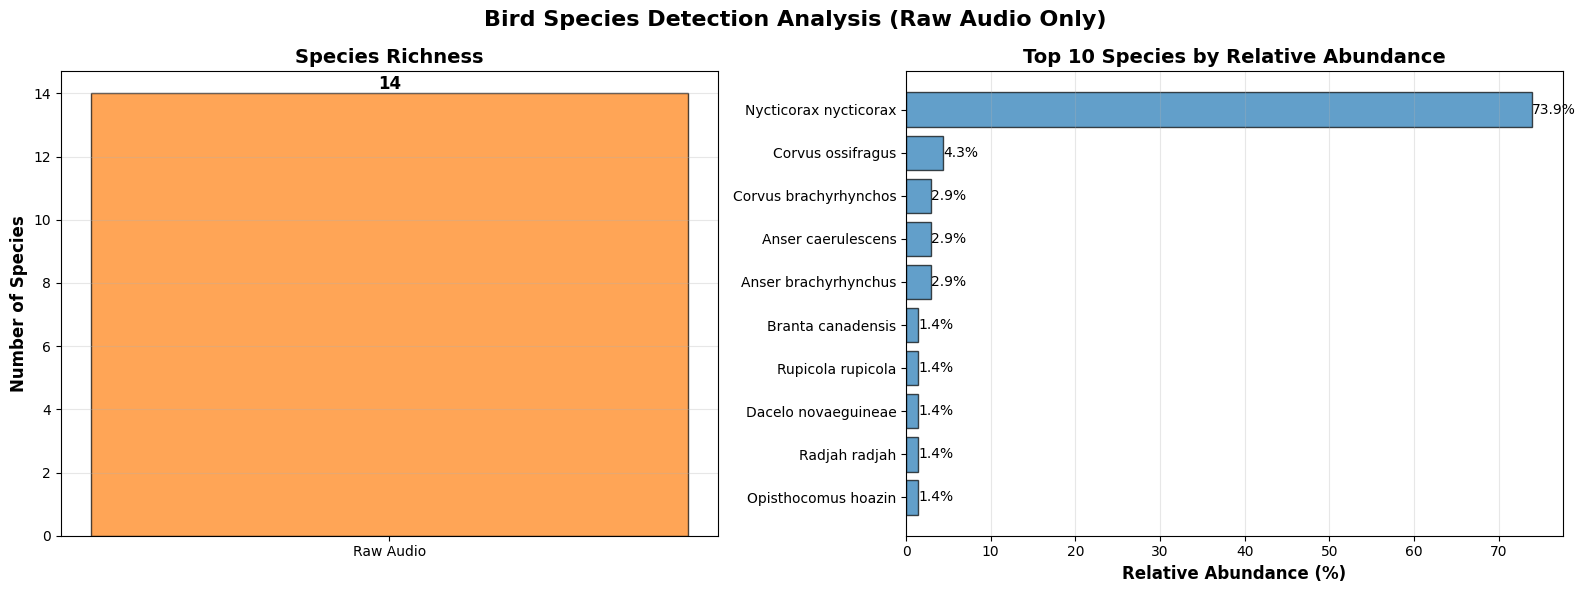


ANALYSIS COMPLETE!


In [ ]:
def plot_results(metrics_raw, filename="bird_analysis.png"):
    """Create visualization for raw audio results only"""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Bird Species Detection Analysis (Raw Audio Only)', 
                 fontsize=16, fontweight='bold')


    ax1 = axes[0]
    ax1.bar(['Raw Audio'], [metrics_raw['richness']], 
            color='#ff7f0e', alpha=0.7, edgecolor='black')
    ax1.set_ylabel('Number of Species', fontsize=12, fontweight='bold')
    ax1.set_title('Species Richness', fontsize=14, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    ax1.text(0, metrics_raw['richness'], f"{metrics_raw['richness']}", 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

    ax2 = axes[1]
    rel_abund = metrics_raw['relative_abundance']
    top_10_abund = sorted(rel_abund.items(), key=lambda x: x[1], reverse=True)[:10]
    species_names = [s[0].split('_')[0] for s in top_10_abund]
    abundances = [s[1] * 100 for s in top_10_abund]
    
    bars = ax2.barh(species_names, abundances, color='#1f77b4', alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Relative Abundance (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Top 10 Species by Relative Abundance', fontsize=14, fontweight='bold')
    ax2.invert_yaxis()
    ax2.grid(axis='x', alpha=0.3)
    for bar in bars:
        width = bar.get_width()
        ax2.text(width, bar.get_y() + bar.get_height()/2., f'{width:.1f}%', 
                 ha='left', va='center', fontsize=10)

    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"\nPlot saved as: {filename}")
    plt.show()


def print_summary(metrics, title):
    """Print text summary of results"""
    print(f"\n{'='*60}")
    print(f"{title:^60}")
    print(f"{'='*60}")
    
    print(f"\n SPECIES RICHNESS: {metrics['richness']} species detected")
    
    print(f"\nTOP 10 SPECIES BY DETECTION FREQUENCY:")
    det_freq = sorted(metrics['detection_frequency'].items(), 
                      key=lambda x: x[1], reverse=True)[:10]
    for i, (species, freq) in enumerate(det_freq, 1):
        print(f"  {i:2d}. {species:40s} {freq*100:5.1f}%")
    
    print(f"\n TOP 10 SPECIES BY RELATIVE ABUNDANCE:")
    rel_abund = sorted(metrics['relative_abundance'].items(), 
                       key=lambda x: x[1], reverse=True)[:10]
    for i, (species, abund) in enumerate(rel_abund, 1):
        count = metrics['raw_counts'][species]
        print(f"  {i:2d}. {species:40s} {abund*100:5.1f}% ({count} detections)")




print("="*60)
print("BIRD SPECIES ANALYSIS: RAW AUDIO ONLY")
print("="*60)

# Load model
print("\nLoading BirdNET model...")
interpreter = load_birdnet_model()
labels = load_labels()
print(f"Model loaded with {len(labels)} species")

print("\n" + "="*60)
print("ANALYZING RAW AUDIO")
print("="*60)
detections_raw, windows_raw = analyze_full_recording(
    "3_S7901_20250204_070000(UTC+7).wav", 
    interpreter, 
    labels,
    min_conf=0.3
)
metrics_raw = calculate_metrics(detections_raw, windows_raw)
print_summary(metrics_raw, "RAW AUDIO RESULTS")

print("\n" + "="*60)
print("CREATING VISUALIZATIONS")
print("="*60)
plot_results(metrics_raw)

print("\n" + "="*60)
print("ANALYSIS COMPLETE!")
print("="*60)


In [3]:
from birdnetlib import Recording
from birdnetlib.analyzer import Analyzer
from datetime import datetime

/Users/ahmed/Desktop/boeung-sne/birdc/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Labels loaded.
load model True
Model loaded.
Labels loaded.
load_species_list_model
Meta model loaded.
read_audio_data
read_audio_data: complete, read  200 chunks.
analyze_recording 3_S7901_20250204_070000(UTC+7).wav
recording has lon/lat
set_predicted_species_list_from_position
return_predicted_species_list
-1
567 species loaded.
[{'common_name': 'Black-crowned Night-Heron', 'scientific_name': 'Nycticorax nycticorax', 'start_time': 6.0, 'end_time': 9.0, 'confidence': 0.9748961329460144, 'label': 'Nycticorax nycticorax_Black-crowned Night-Heron'}, {'common_name': 'Black-crowned Night-Heron', 'scientific_name': 'Nycticorax nycticorax', 'start_time': 51.0, 'end_time': 54.0, 'confidence': 0.4946873188018799, 'label': 'Nycticorax nycticorax_Black-crowned Night-Heron'}, {'common_name': 'Black-crowned Night-Heron', 'scientific_name': 'Nycticorax nycticorax', 'start_time': 57.0, 'end_time': 60.0, 'confidence': 0.12229124456644058, 'label': 'Nycticorax nycticorax_Black-crowned Night-Heron'}, {

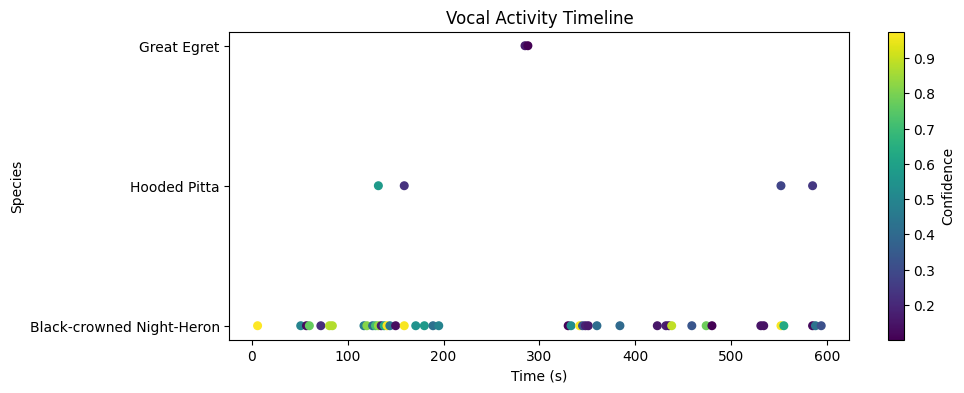

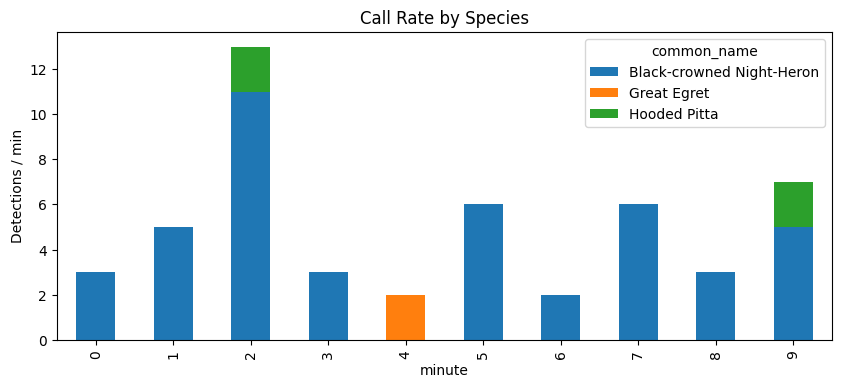

In [13]:
analyzer = Analyzer()
recording = Recording(
    analyzer,
    "3_S7901_20250204_070000(UTC+7).wav",
    lat=11.406949,
    lon=105.394883,

)
recording.analyze()
print(recording.detections)


import pandas as pd, matplotlib.pyplot as plt

df = pd.DataFrame(recording.detections)
plt.figure(figsize=(10,4))
plt.scatter(df["start_time"], df["common_name"], c=df["confidence"], cmap="viridis", s=30)
plt.colorbar(label="Confidence")
plt.xlabel("Time (s)")
plt.ylabel("Species")
plt.title("Vocal Activity Timeline")
plt.show()

df["minute"] = (df["start_time"] / 60).astype(int)
call_rate = df.groupby(["minute", "common_name"]).size().unstack(fill_value=0)
call_rate.plot(kind="bar", stacked=True, figsize=(10,4))
plt.ylabel("Detections / min")
plt.title("Call Rate by Species")
plt.show()